In [1]:
import pickle
import numpy as np
import cv2

In [2]:
text_lines = pickle.load(open("result.pkl","rb"))

In [3]:
text_lines

[OrderedDict([('x0', 37.0),
              ('y0', 474.0),
              ('x1', 149.0),
              ('y1', 472.0),
              ('x2', 150.0),
              ('y2', 511.0),
              ('x3', 38.0),
              ('y3', 513.0),
              ('score', 0.3037465810775757)]),
 OrderedDict([('x0', 37.0),
              ('y0', 155.0),
              ('x1', 146.0),
              ('y1', 154.0),
              ('x2', 146.0),
              ('y2', 190.0),
              ('x3', 37.0),
              ('y3', 192.0),
              ('score', 0.2641437351703644)]),
 OrderedDict([('x0', 261.0),
              ('y0', 425.0),
              ('x1', 362.0),
              ('y1', 426.0),
              ('x2', 361.0),
              ('y2', 463.0),
              ('x3', 261.0),
              ('y3', 462.0),
              ('score', 0.3049818277359009)]),
 OrderedDict([('x0', 119.0),
              ('y0', 919.0),
              ('x1', 334.0),
              ('y1', 921.0),
              ('x2', 334.0),
              ('y2', 9

In [4]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [5]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [6]:
image = cv2.imread("./demo_images/20000-leagues-006.jpg")

In [7]:

def get_patch(image, d):
    
    pts0 = [(d["x{}".format(i)], d["y{}".format(i)]) for i in range(4)]
    warped = four_point_transform(image, np.array(pts0))
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)



    (thresh, im_bw) = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
    im_bw = cv2.morphologyEx(im_bw, cv2.MORPH_OPEN, kernel)
    (thresh, im_bw) = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
    im_bw = cv2.morphologyEx(im_bw, cv2.MORPH_OPEN, kernel)
    im_bw = cv2.bitwise_not(im_bw)
    return warped,im_bw

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

all_images = []
for x in text_lines:
    im_bw = get_patch(image, x)
    all_images.append(im_bw)

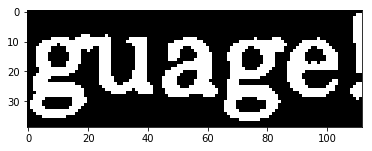

In [9]:
test = all_images[0][1]
plt.imshow(test,cmap="gray")